In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2cdc22551e0>,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397'}

In [10]:
# Find the most recent date in the data set.

# https://stackoverflow.com/questions/8551952/how-to-get-last-record
last_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


# https://docs.python.org/3/library/datetime.html
# https://dev.to/lavary/about-attributeerror-module-datetime-has-no-attribute-strptime-in-python-1k53
# https://stackoverflow.com/questions/25015711/time-data-does-not-match-format
last_date = last_row[0]
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
last_date

datetime.datetime(2017, 8, 23, 0, 0)

<Axes: >

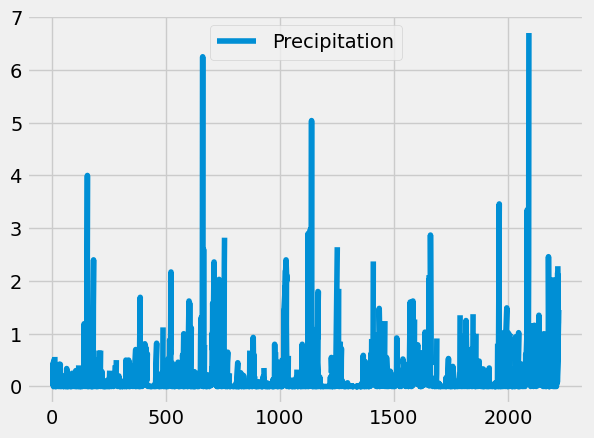

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# https://www.geeksforgeeks.org/how-to-add-and-subtract-days-using-datetime-in-python/
date_difference = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_difference).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = {}
i = 1
for row in precipitation_query:
    data[i] = [row[0], row[1]]
    i += 1
df = pd.DataFrame.from_dict(data, orient='index', columns=('Date', 'Precipitation'))

# Sort the dataframe by date
sorted_df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_query = session.query(Measurement.station).distinct().count()
station_query

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
station_group_query_2 = session.query(Measurement.station, sqlalchemy.func.count(Measurement.station)).\
                                group_by(Measurement.station).order_by(sqlalchemy.func.count(Measurement.station).desc()).all()

list_1 = [x for x in station_group_query_2]
list_1


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_group_query_3 = session.query(Measurement.station, sqlalchemy.func.min(Measurement.tobs), \
                                                           sqlalchemy.func.max(Measurement.tobs),  \
                                                           sqlalchemy.func.avg(Measurement.tobs),).\
                                                           filter((Measurement.station == 'USC00519281'))

list_2 = [x for x in station_group_query_3]

print(f'Station: {list_2[0][0]}')
print(f'Minimum temperature: {list_2[0][1]}')
print(f'Maximum temperature: {list_2[0][2]}')
print(f'Average temperature: {round(list_2[0][3], 2)}')

Station: USC00519281
Minimum temperature: 54.0
Maximum temperature: 85.0
Average temperature: 71.66


<Axes: ylabel='Frequency'>

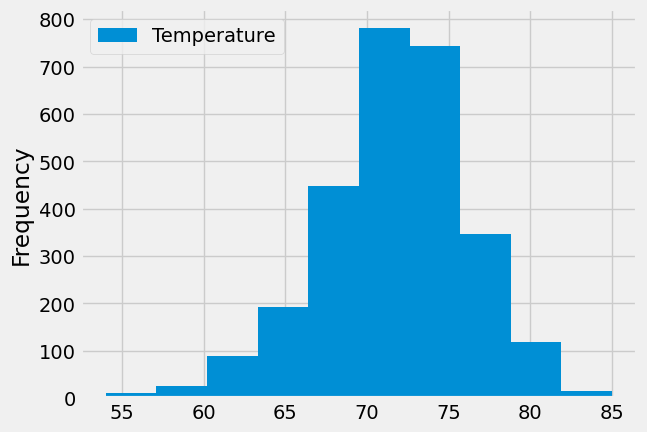

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# -------------------------------------------------------

# https://stackoverflow.com/questions/8551952/how-to-get-last-record
last_station_row = session.query(Measurement.date).\
                           filter(Measurement.station == 'USC00519281').\
                           order_by(Measurement.date.desc()).first()

# https://docs.python.org/3/library/datetime.html
# https://dev.to/lavary/about-attributeerror-module-datetime-has-no-attribute-strptime-in-python-1k53
# https://stackoverflow.com/questions/25015711/time-data-does-not-match-format
dt.datetime.strptime(last_station_row[0], "%Y-%m-%d")

# https://www.geeksforgeeks.org/how-to-add-and-subtract-days-using-datetime-in-python/
station_date_difference = last_date - dt.timedelta(days=365)

# -------------------------------------------------------------

station_group_query_4 = session.query(Measurement.date, Measurement.tobs).\
                                      filter((Measurement.station == 'USC00519281') and \
                                             (Measurement.date >= station_date_difference)).\
                                      order_by(Measurement.date.desc())

list_3 = [x for x in station_group_query_4]

temp_dict = {}

for x in list_3:
    temp_dict[x[0]] = x[1]

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Temperature'])
temp_df.plot(kind='hist')

# Close Session

In [17]:
# Close Session
session.close()